In [1]:
# TODO: ~/src/anaconda3/envs/tf/lib/python3.6/site-packages/textgenrnn.bak/

#from textgenrnn import textgenrnn
from textgenrnn.textgenrnn import textgenrnn

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from textgenrnn.textgenrnn import utils

%matplotlib inline

def attention_map(prediction_text, x_lbls, weights):
    # https://github.com/datalogue/keras-attention/blob/master/visualize.py
    '''if '<pad>' in x_lbls:
        # replace "" after last "<pad>" with another "pad"
        last_pad = len(x_lbls) - 1 - x_lbls[::-1].index('<pad>')
        if last_pad + 1 < len(x_lbls):
            x_lbls[last_pad + 1] = '<pad>'''
            
    #print(prediction_text, x_lbls)
    
    # get the activation map
    activation_map = [a[0] for a in weights]

    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')

    # add labels
    ax.set_xticks(range(model_cfg['max_length']))
    ax.set_xticklabels([f'"{l}"' for l in x_lbls])

    ax.set_yticks(range(len(weights)))
    ax.set_yticklabels([f'"{t}"' for t in prediction_text])
    ax.yaxis.tick_right()

    ax.set_xlabel('History')
    ax.set_ylabel('Next word')

    #f.savefig(os.path.join(HERE, 'attention_maps', text.replace('/', '')+'.pdf'), bbox_inches='tight')
    return f, i
    
meta_token = '<s>'
pad_token = '<pad>'
    
def sample(textgen, temperature=0.5, map_attention=True, max_len=20, seed=None):
    # suppress runtime warning
    plt.rcParams.update({'figure.max_open_warning': max_len + 1})
    
    from keras.models import Model
    import re

    # https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
    attn_model = Model(inputs=textgen.model.input, outputs=[textgen.model.get_layer('attention').output[1], textgen.model.output])
    
    next_word = ''
    text = [meta_token] + list(seed) if seed else [meta_token]
    last_lbls = [pad_token]*(model_cfg['max_length'] - 1) + [meta_token]
    attn_weights = []

    if map_attention:
        plt.clf()
    while next_word != meta_token and len(text) < max_len:
        encoded_text = utils.textgenrnn_encode_sequence(text, textgen.vocab, model_cfg['max_length'])

        preds = attn_model.predict(encoded_text)
        attn = preds[0]
        full_pred = preds[1]

        next_index = utils.textgenrnn_sample(full_pred[0], temperature)
        next_word = textgen.indices_char[next_index]

        text += [next_word]
        
        if map_attention:
            attn_lbl = list([pad_token]*max(model_cfg['max_length']-len(text), 0) + text[-model_cfg['max_length']:])
            attention_map([next_word], last_lbls, [attn])
            attn_weights.append(attn)
            last_lbls = attn_lbl

    text_joined = ' '.join(text[1:])
    punct = '\\n\\t'
    print(f'temperature: {temperature}; max_len: {max_len}')
    print(re.sub(" ([{}]) ".format(punct), r'\1', text_joined))
    if map_attention:
        # add colorbar [left, bottom, width, height]
        f, i = attention_map(text[1:], [], attn_weights)
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Weight', labelpad=4)
        plt.show()


from keras.callbacks import Callback

class sample_after_epoch(Callback):
    def __init__(self, textgen, sample_epochs, temperature=0.5, map_attention=True, max_len=20):
        self.textgen = textgen
        self.sample_epochs = sample_epochs
        self.temperature = temperature
        self.map_attention = map_attention
        self.max_len = max_len

    def on_epoch_end(self, epoch, logs={}):
        if self.sample_epochs > 0 and (epoch+1) % self.sample_epochs == 0:
            sample(self.textgen, temperature=self.temperature, map_attention=self.map_attention, max_len=self.max_len)

In [3]:
model_cfg = {
    'rnn_size': 128,
    'rnn_layers': 4,
    'rnn_bidirectional': True,
    'max_length': 10,#5,#300,
    'max_words': 100000,
    'dim_embeddings': 300,
    'word_level': True,
}

train_cfg = {
    'line_delimited': True,
    'num_epochs': 1,#10,
    'gen_epochs': 0,#1,#2,
    'sample_epochs': 1,
    'batch_size': 512,
    'train_size': 0.8,
    'dropout': 0.1,
    'max_gen_length': 300,
    'validation': True,
    'is_csv': False
}

37,768 texts collected.
Training new model w/ 4-layer, 128-cell Bidirectional LSTMs
Training on 5,212,896 word sequences.
Epoch 1/1
10181/10181 [==============================] - 660s 65ms/step - loss: 4.4031 - val_loss: 4.0956
temperature: 0.5; max_len: 20
posted by : on december 21 , 2014 * * * * * * * i have a lot


<Figure size 432x288 with 0 Axes>

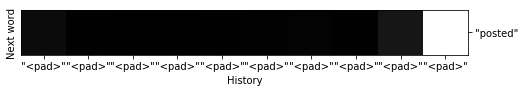

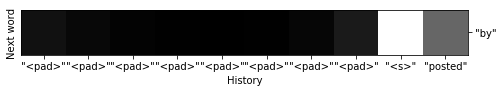

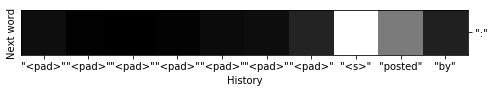

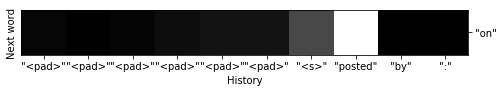

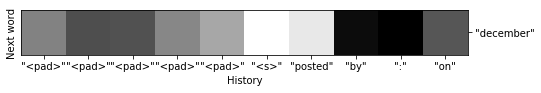

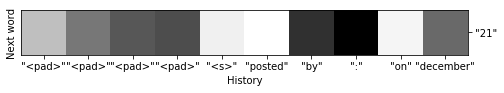

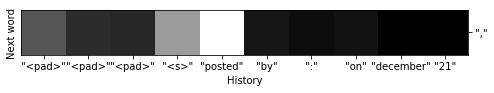

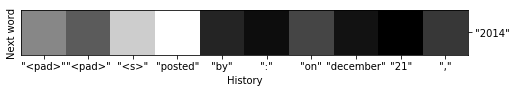

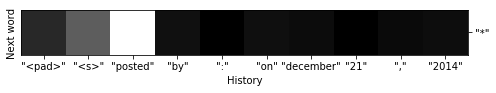

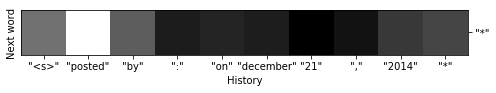

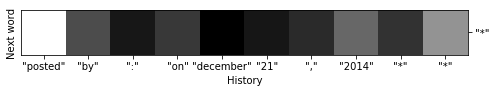

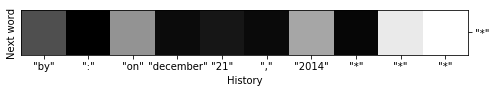

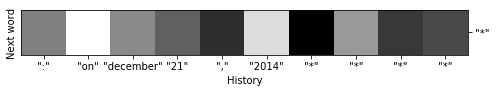

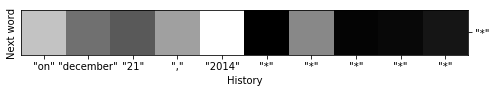

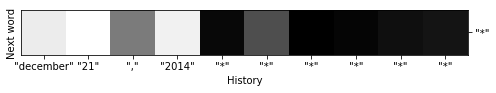

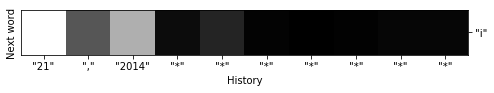

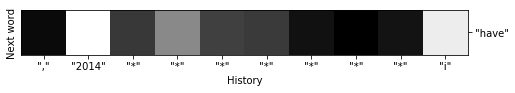

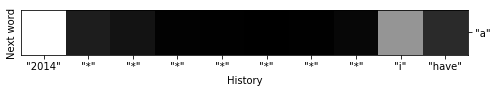

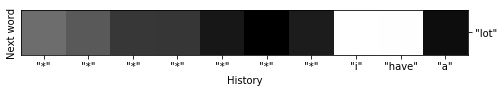

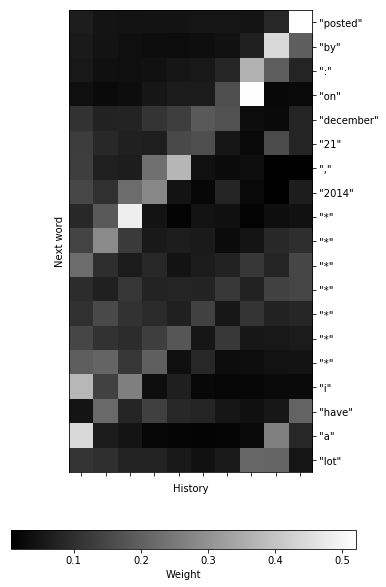

In [4]:
from pathlib import Path

data_path = Path('../datasets/')
model_name = 'reviews_lines'
textgen = textgenrnn(name=model_name)

train_function = textgen.train_from_file if train_cfg['line_delimited'] else textgen.train_from_largetext_file

train_function(
    file_path=str(data_path / f'{model_name}.txt'),
    new_model=True,
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'],
    callbacks=[sample_after_epoch(textgen, train_cfg['sample_epochs'])])

In [5]:
train_cfg['num_epochs'] = 10
train_cfg['sample_epochs'] = 2

37,768 texts collected.
Training on 4,156,529 word sequences.
Epoch 1/10
8118/8118 [==============================] - 533s 66ms/step - loss: 4.6423 - val_loss: 4.6592
Epoch 2/10
8118/8118 [==============================] - 520s 64ms/step - loss: 4.4112 - val_loss: 4.6503
temperature: 0.5; max_len: 20
posted march 2016 by tim kaplan under new music a little bit of a departure from the original and


<Figure size 432x288 with 0 Axes>

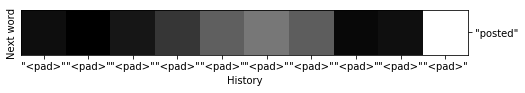

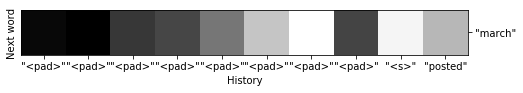

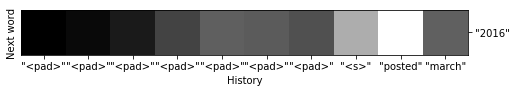

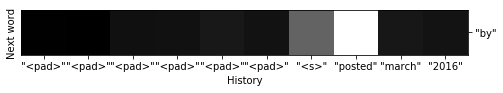

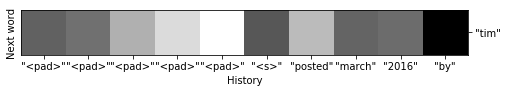

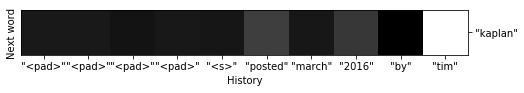

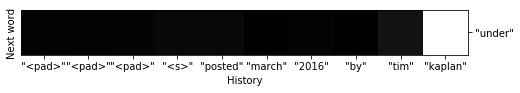

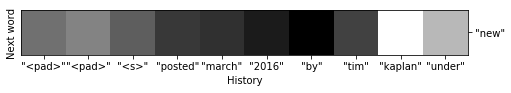

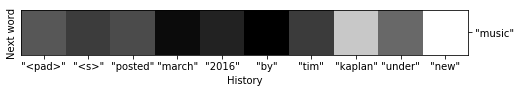

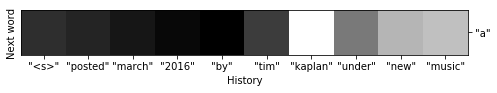

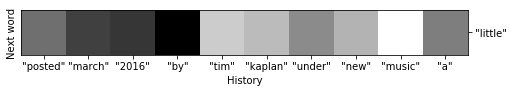

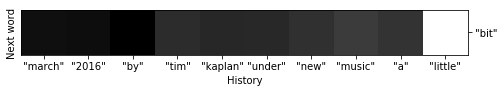

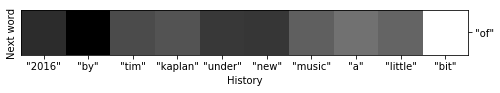

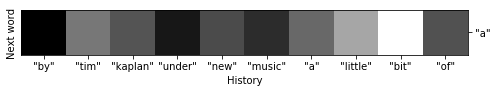

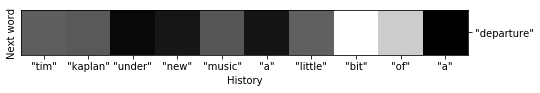

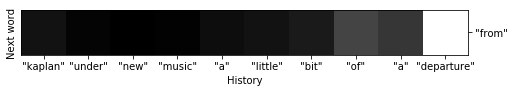

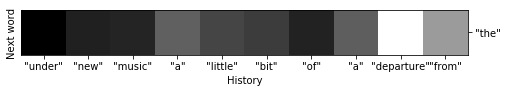

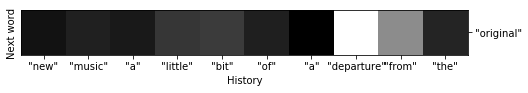

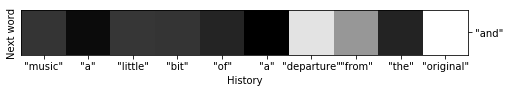

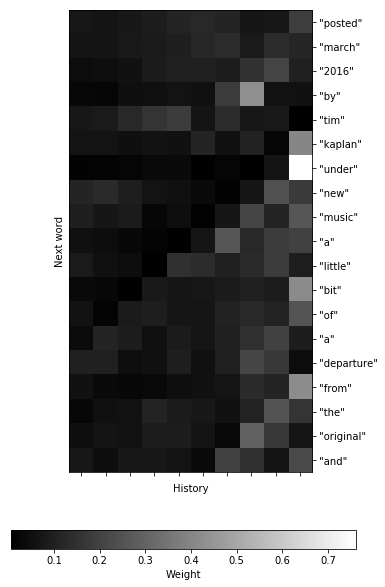

Epoch 3/10
8118/8118 [==============================] - 521s 64ms/step - loss: 4.2727 - val_loss: 4.6379
Epoch 4/10
8118/8118 [==============================] - 525s 65ms/step - loss: 4.1393 - val_loss: 4.7252
temperature: 0.5; max_len: 20
after his success with his debut single featuring the vocals of fellow aussie chance the rapper and social experiment


<Figure size 432x288 with 0 Axes>

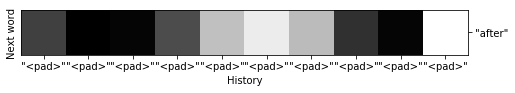

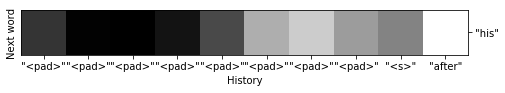

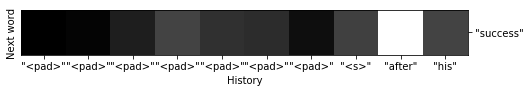

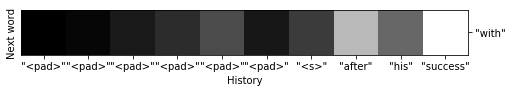

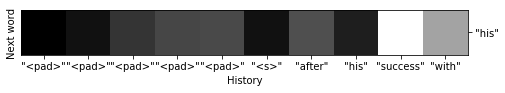

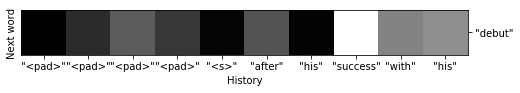

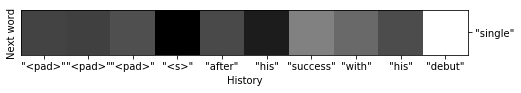

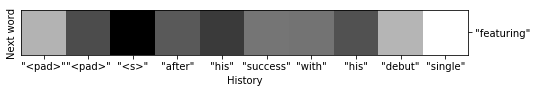

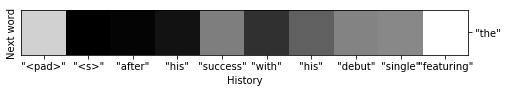

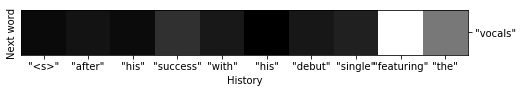

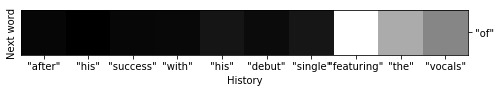

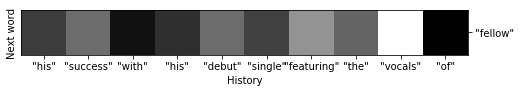

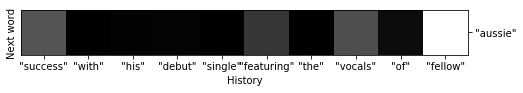

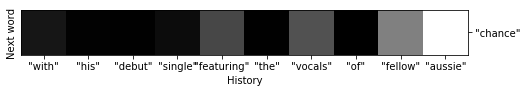

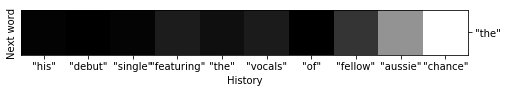

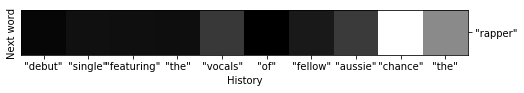

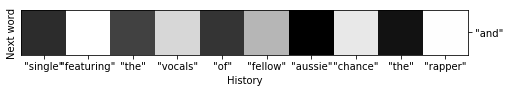

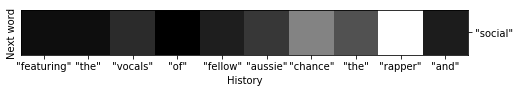

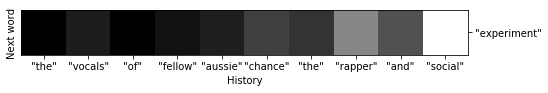

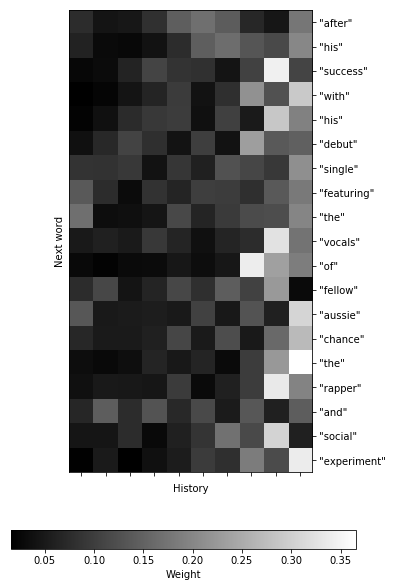

Epoch 5/10
8118/8118 [==============================] - 518s 64ms/step - loss: 3.9957 - val_loss: 4.7082
Epoch 6/10
8118/8118 [==============================] - 522s 64ms/step - loss: 3.9163 - val_loss: 4.7153
temperature: 0.5; max_len: 20
having recently been a huge year for the duo comprised of aaron and benny blanco and two inch punch


<Figure size 432x288 with 0 Axes>

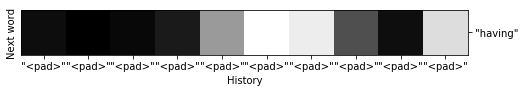

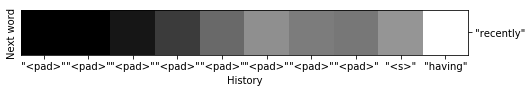

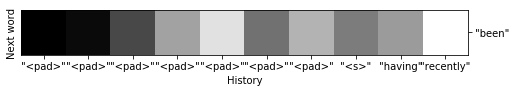

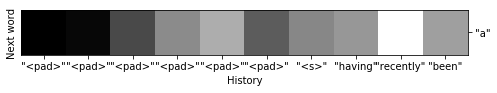

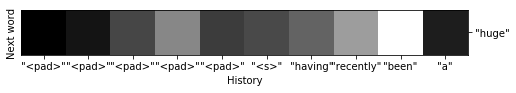

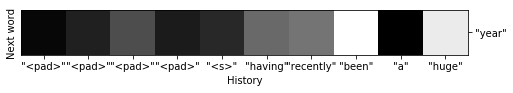

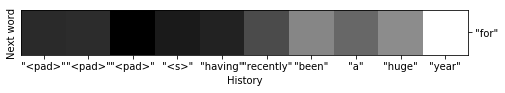

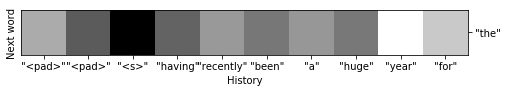

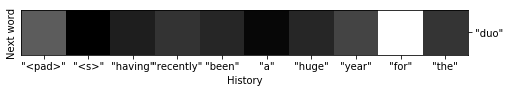

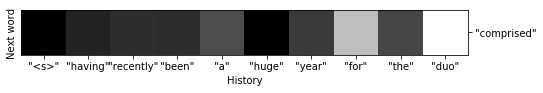

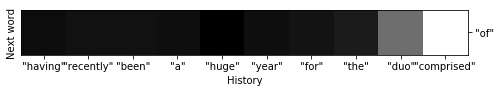

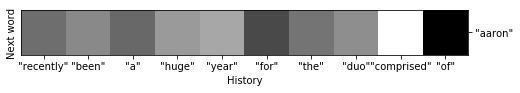

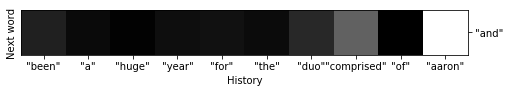

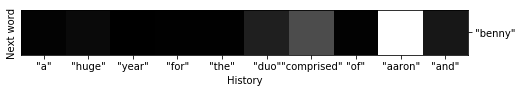

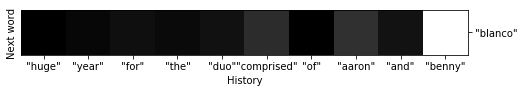

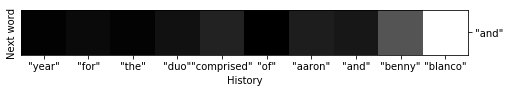

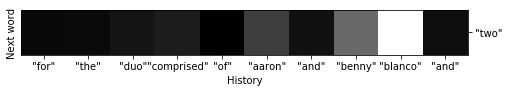

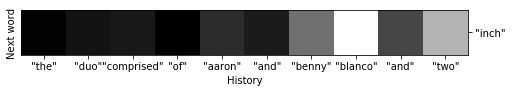

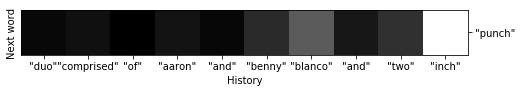

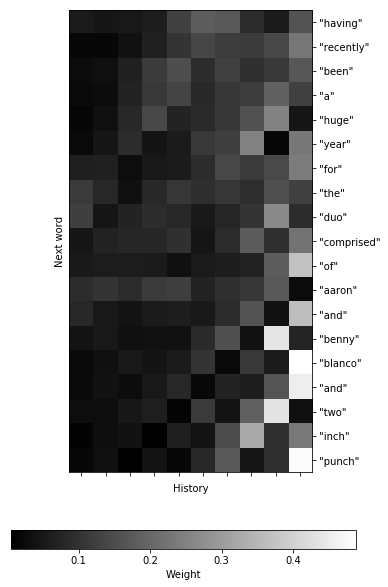

Epoch 7/10
8118/8118 [==============================] - 523s 64ms/step - loss: 3.8285 - val_loss: 4.6907
Epoch 8/10
8118/8118 [==============================] - 524s 65ms/step - loss: 3.7067 - val_loss: 4.7780
temperature: 0.5; max_len: 20
is the latest single from uk producer joe goddard , which was released earlier this year and now the


<Figure size 432x288 with 0 Axes>

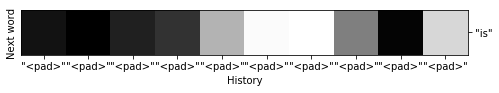

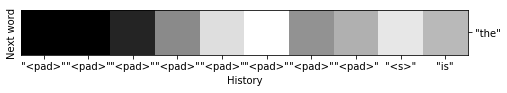

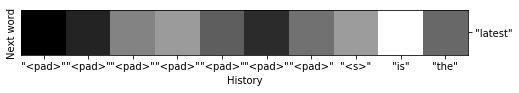

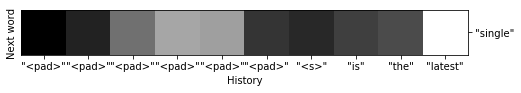

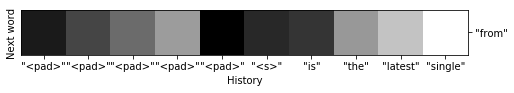

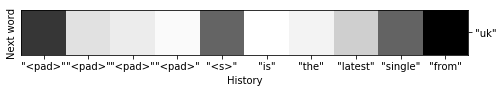

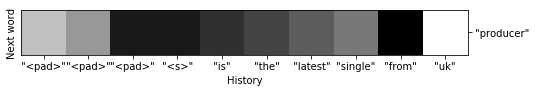

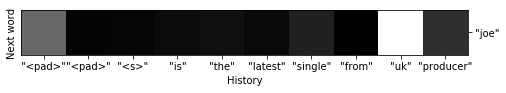

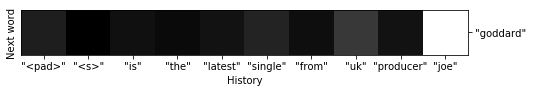

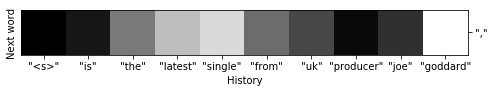

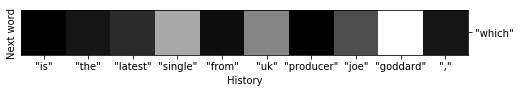

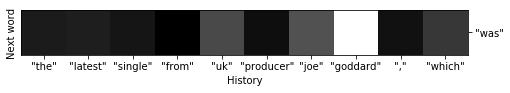

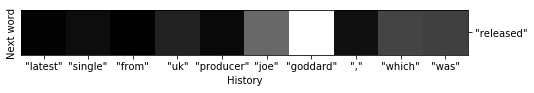

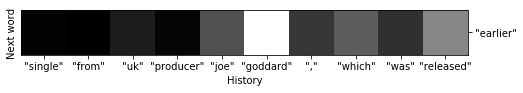

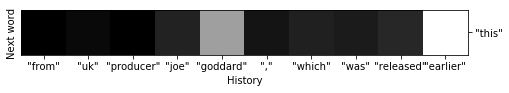

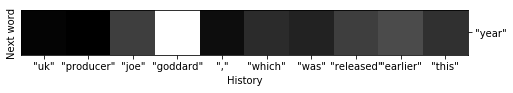

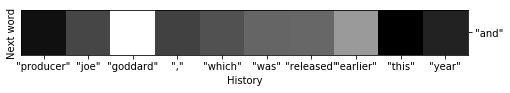

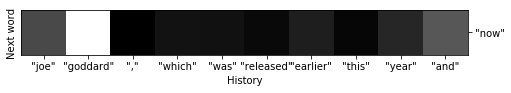

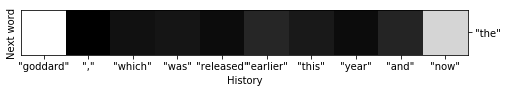

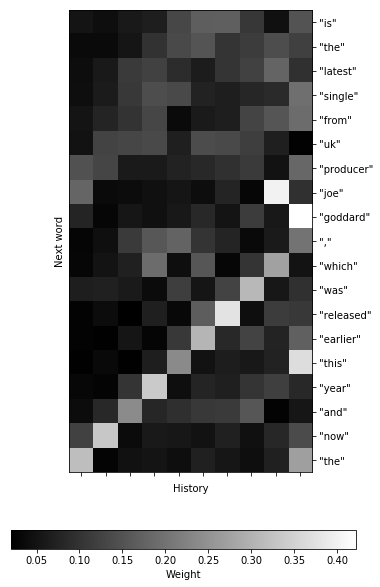

Epoch 9/10
8118/8118 [==============================] - 518s 64ms/step - loss: 3.6039 - val_loss: 4.7606
Epoch 10/10
8118/8118 [==============================] - 518s 64ms/step - loss: 3.5252 - val_loss: 4.7515
temperature: 0.5; max_len: 20
image via | | | x indie shuffle app free on google play install x indie shuffle app free


<Figure size 432x288 with 0 Axes>

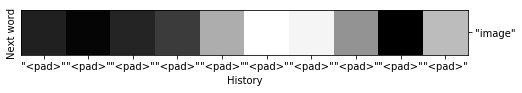

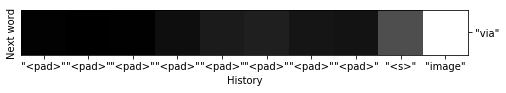

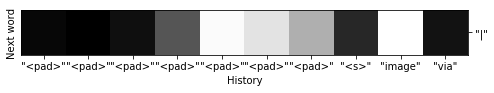

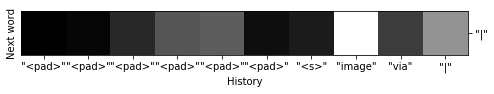

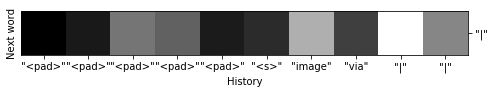

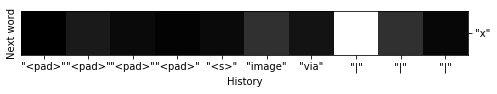

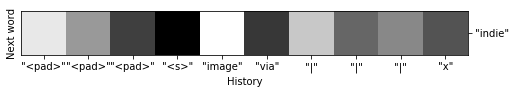

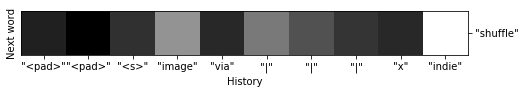

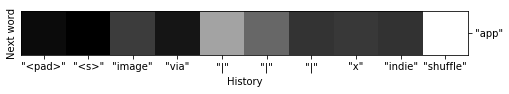

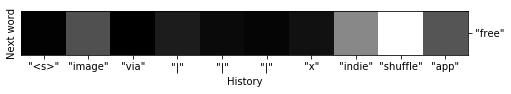

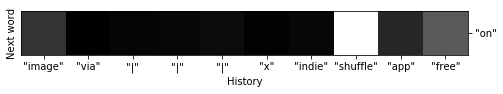

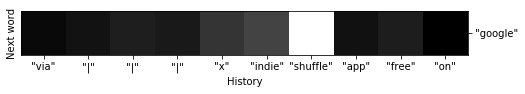

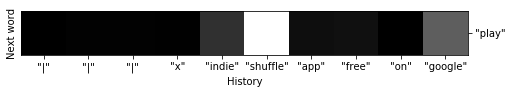

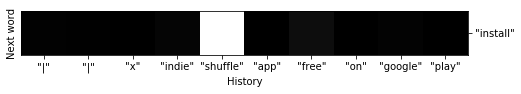

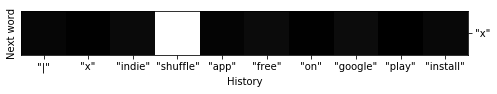

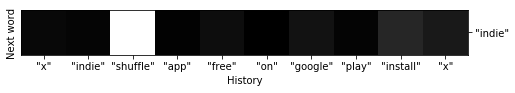

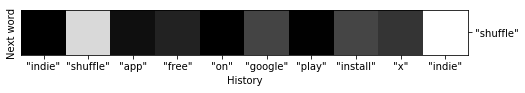

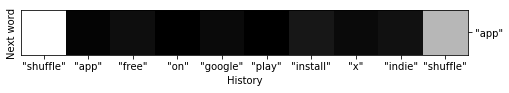

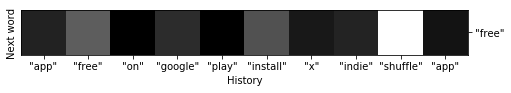

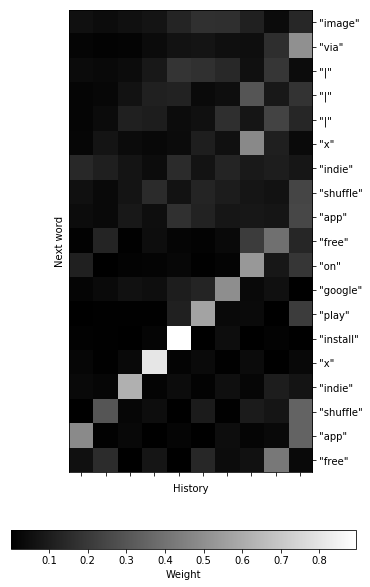

In [6]:
train_function(
    file_path=str(data_path / f'{model_name}.txt'),
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'],
    callbacks=[sample_after_epoch(textgen, train_cfg['sample_epochs'])])

temperature: 1.0; max_len: 20
chloe black has announced her next fantastic release called black sun , which is finally set to release another


<Figure size 432x288 with 0 Axes>

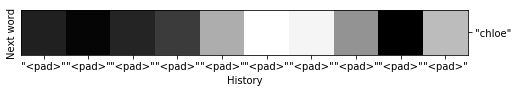

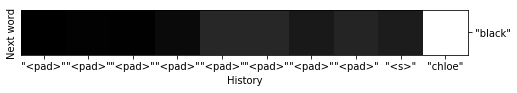

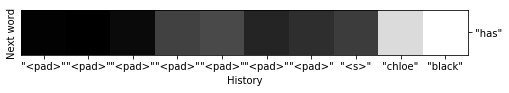

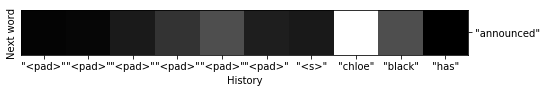

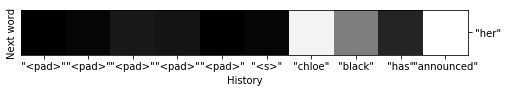

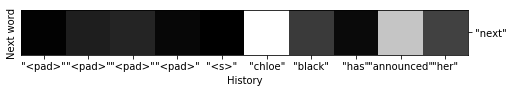

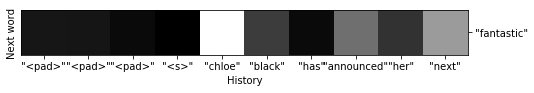

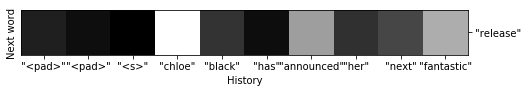

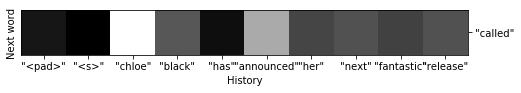

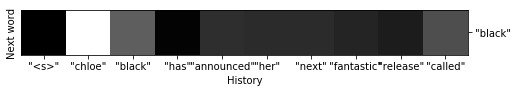

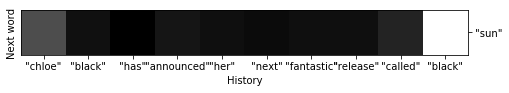

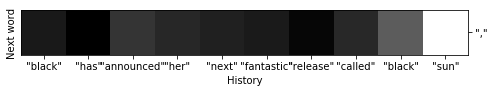

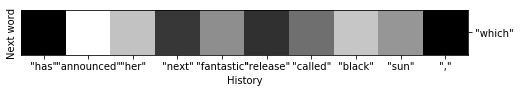

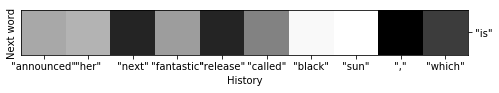

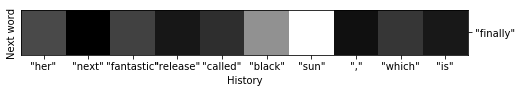

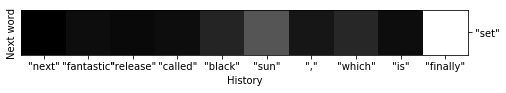

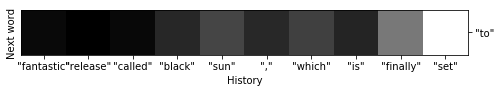

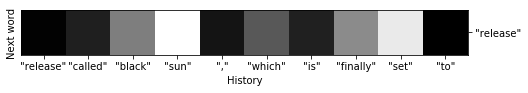

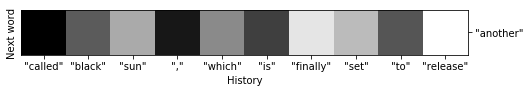

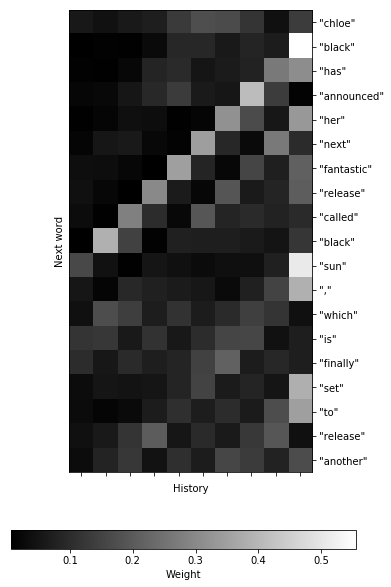

In [7]:
sample(textgen, temperature=1.0)